In [1]:
import pandas as pd
import numpy as np
import os
import time
import polars as pl
from pathlib import Path
import pyarrow
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
#https://github.com/thampiman/reverse-geocoder
import reverse_geocoder as rg
import folium
from folium.plugins import HeatMap
import random
import joblib

c:\Users\lucas\anaconda3\envs\lab\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Can we predict mission outcome from any of the data points involved? 

-Lets clean the data and setup our df

In [2]:
vraw = pl.read_parquet("Data/THOR_Vietnam_Bombing_Operations.parquet")
vraw.head()

shape: (5, 47)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ THOR_DATA ┆ COUNTRYFL ┆ MILSERVIC ┆ MSNDATE   ┆ … ┆ RELEASEFL ┆ RESULTSBD ┆ TIMEOFFTA ┆ WEAPONSL │
│ _VIET_ID  ┆ YINGMISSI ┆ E         ┆ ---       ┆   ┆ TSPEED    ┆ A         ┆ RGET      ┆ OADEDWEI │
│ ---       ┆ ON        ┆ ---       ┆ str       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ GHT      │
│ i64       ┆ ---       ┆ str       ┆           ┆   ┆ i64       ┆ str       ┆ i64       ┆ ---      │
│           ┆ str       ┆           ┆           ┆   ┆           ┆           ┆           ┆ i64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 351       ┆ UNITED    ┆ USAF      ┆ 6/5/1971  ┆ … ┆ null      ┆ null      ┆ 1005      ┆ 0        │
│           ┆ STATES OF ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ AMERICA   ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2         ┆ UNITED    ┆ USAF      ┆ 12/26/197 ┆ … ┆ null      ┆ null      ┆ 530       ┆ 0        │
│           ┆ STATES OF ┆           ┆ 2         ┆   ┆           ┆           ┆           ┆          │
│           ┆ AMERICA   ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 3         ┆ UNITED    ┆ USAF      ┆ 7/28/1973 ┆ … ┆ null      ┆ null      ┆ 730       ┆ 0        │
│           ┆ STATES OF ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ AMERICA   ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 4         ┆ UNITED    ┆ USAF      ┆ 2/2/1970  ┆ … ┆ null      ┆ SECONDARY ┆ 1415      ┆ 17400    │
│           ┆ STATES OF ┆           ┆           ┆   ┆           ┆ FIRE      ┆           ┆          │
│           ┆ AMERICA   ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 5         ┆ VIETNAM   ┆ VNAF      ┆ 10/8/1970 ┆ … ┆ null      ┆ RNO       ┆ 1240      ┆ 0        │
│           ┆ (SOUTH)   ┆           ┆           ┆   ┆           ┆ WEATHER   ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

### Looks like we have alot of columns, many NULL values, and some repetitive info. 1 Million, 48 thousand rows is alot, hopefully we have enough when we are done cleaning

### RESULTSBDA is the prediction we want to make, so any columns that do not contribute meaningfully or have NULL values in significant place will have to be dropped. 

In [3]:
tva = vraw.drop([
    'SOURCEID', 'SOURCERECORD', 'ID', 'GEOZONE', 'AIRFORCEGROUP',
    'AIRFORCESQDN', 'CALLSIGN', 'FLTHOURS', 'UNIT',
    'TGTORIGCOORDS', 'TGTORIGCOORDSFORMAT', 'MFUNC_DESC_CLASS'
])
targs_order = ['THOR_DATA_VIET_ID',
 'COUNTRYFLYINGMISSION',
 'MILSERVICE',
 'MSNDATE',
 'AIRCRAFT_ROOT',
 'TAKEOFFLOCATION',
 'TGTTYPE',
 'NUMWEAPONSDELIVERED',
 'WEAPONTYPE',
 'WEAPONTYPEWEIGHT',
 'MFUNC_DESC',
 'MISSIONID',
 'NUMOFACFT',
 'PERIODOFDAY',
 'TGTCOUNTRY',
 "TGTLATDD_DDD_WGS84",
 "TGTLONDDD_DDD_WGS84",
 'RESULTSBDA',
 'WEAPONSLOADEDWEIGHT']
tva = tva.select(targs_order)
tva.null_count() 

shape: (1, 19)
┌────────────┬───────────┬───────────┬─────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ THOR_DATA_ ┆ COUNTRYFL ┆ MILSERVIC ┆ MSNDATE ┆ … ┆ TGTLATDD_ ┆ TGTLONDDD ┆ RESULTSBD ┆ WEAPONSLO │
│ VIET_ID    ┆ YINGMISSI ┆ E         ┆ ---     ┆   ┆ DDD_WGS84 ┆ _DDD_WGS8 ┆ A         ┆ ADEDWEIGH │
│ ---        ┆ ON        ┆ ---       ┆ u32     ┆   ┆ ---       ┆ 4         ┆ ---       ┆ T         │
│ u32        ┆ ---       ┆ u32       ┆         ┆   ┆ u32       ┆ ---       ┆ u32       ┆ ---       │
│            ┆ u32       ┆           ┆         ┆   ┆           ┆ u32       ┆           ┆ u32       │
╞════════════╪═══════════╪═══════════╪═════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 0          ┆ 852       ┆ 759       ┆ 0       ┆ … ┆ 253590    ┆ 253590    ┆ 983220    ┆ 0         │
└────────────┴───────────┴───────────┴─────────┴───┴───────────┴───────────┴───────────┴───────────┘

# 983,220 missions do not have BDA, so we cannot include these in our prediction

In [4]:
tva_bda = tva.filter(pl.col("RESULTSBDA").is_not_null())
tva_bda = tva_bda.filter(pl.col("TGTTYPE").is_not_null())
tva_bda = tva_bda.filter(pl.col("COUNTRYFLYINGMISSION").is_not_null())
tva_bda = tva_bda.filter(pl.col("TAKEOFFLOCATION").is_not_null())
tva_bda = tva_bda.filter(pl.col("MFUNC_DESC").is_not_null())
tva_bda = tva_bda.filter(pl.col("PERIODOFDAY").is_not_null())
tva_bda = tva_bda.filter(pl.col("PERIODOFDAY").is_in(['D', 'N'])) #Because there are 2 rows with a value of '5' or '0'.....
tva_bda = tva_bda.filter(pl.col("TGTLONDDD_DDD_WGS84").is_not_null())
tva_bda = tva_bda.filter(pl.col("TGTLATDD_DDD_WGS84").is_not_null())
tva_bda.describe()

shape: (9, 20)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ THOR_DATA ┆ COUNTRYFL ┆ MILSERVIC ┆ … ┆ TGTLATDD_ ┆ TGTLONDDD ┆ RESULTSBD ┆ WEAPONSL │
│ ---       ┆ _VIET_ID  ┆ YINGMISSI ┆ E         ┆   ┆ DDD_WGS84 ┆ _DDD_WGS8 ┆ A         ┆ OADEDWEI │
│ str       ┆ ---       ┆ ON        ┆ ---       ┆   ┆ ---       ┆ 4         ┆ ---       ┆ GHT      │
│           ┆ f64       ┆ ---       ┆ str       ┆   ┆ f64       ┆ ---       ┆ str       ┆ ---      │
│           ┆           ┆ str       ┆           ┆   ┆           ┆ f64       ┆           ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 54150.0   ┆ 54150     ┆ 54150     ┆ … ┆ 54150.0   ┆ 54150.0   ┆ 54150     ┆ 54150.0  │
│ null_coun ┆ 0.0       ┆ 0         ┆ 0         ┆ … ┆ 0.0       ┆ 0.0       ┆ 0         ┆ 0.0      │
│ t         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ mean      ┆ 222598.77 ┆ null      ┆ null      ┆ … ┆ 14.9799   ┆ 106.26890 ┆ null      ┆ 59772.44 │
│           ┆ 9501      ┆           ┆           ┆   ┆           ┆ 6         ┆           ┆ 2105     │
│ std       ┆ 143800.26 ┆ null      ┆ null      ┆ … ┆ 2.851804  ┆ 1.281814  ┆ null      ┆ 378671.7 │
│           ┆ 5292      ┆           ┆           ┆   ┆           ┆           ┆           ┆ 48738    │
│ min       ┆ 4.0       ┆ AUSTRALIA ┆ KAF       ┆ … ┆ 8.386111  ┆ 97.805555 ┆ CRATERED  ┆ 0.0      │
│ 25%       ┆ 106213.0  ┆ null      ┆ null      ┆ … ┆ 11.995    ┆ 105.75027 ┆ null      ┆ 0.0      │
│           ┆           ┆           ┆           ┆   ┆           ┆ 7         ┆           ┆          │
│ 50%       ┆ 213402.0  ┆ null      ┆ null      ┆ … ┆ 15.71     ┆ 106.38861 ┆ null      ┆ 0.0      │
│           ┆           ┆           ┆           ┆   ┆           ┆ 1         ┆           ┆          │
│ 75%       ┆ 319395.0  ┆ null      ┆ null      ┆ … ┆ 16.883611 ┆ 107.02527 ┆ null      ┆ 26000.0  │
│           ┆           ┆           ┆           ┆   ┆           ┆ 7         ┆           ┆          │
│ max       ┆ 611407.0  ┆ VIETNAM   ┆ VNAF      ┆ … ┆ 23.899166 ┆ 112.14722 ┆ WOUNDED   ┆ 6.56e7   │
│           ┆           ┆ (SOUTH)   ┆           ┆   ┆           ┆ 2         ┆ BY AIR    ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

### Down to just 54,000 rows. Lets switch to pandas now that we are below 100k rows and see what we can get thats still interesting. We still have some nulls in weapon type and target country

In [5]:
df = tva_bda.to_pandas()
df[df.TGTCOUNTRY.isnull()].head(5)

THOR_DATA_VIET_ID      COUNTRYFLYINGMISSION MILSERVICE     MSNDATE  \
51                 340           VIETNAM (SOUTH)       VNAF  12/25/1970   
81                 704  UNITED STATES OF AMERICA       USAF   5/28/1970   
92                 779  UNITED STATES OF AMERICA       USAF   7/29/1970   
106                879           VIETNAM (SOUTH)       VNAF    5/2/1970   
124                981  UNITED STATES OF AMERICA       USAF   6/11/1970   

    AIRCRAFT_ROOT TAKEOFFLOCATION            TGTTYPE  NUMWEAPONSDELIVERED  \
51             A1        BIEN HOA          FOX HOLES                    0   
81           F100        BIEN HOA  CONFIRM ENEMY LOC                    0   
92             F4         PHU CAT  CONFIRM ENEMY LOC                   12   
106           A37       NHA TRANG      PERSONNEL\ANY                    8   
124          F100         TUY HOA  CONFIRM ENEMY LOC                    4   

                 WEAPONTYPE  WEAPONTYPEWEIGHT         MFUNC_DESC MISSIONID  \
51                     None                 0  CLOSE AIR SUPPORT      D386   
81                     None                 0  CLOSE AIR SUPPORT      4183   
92   MK 82 GP BOMB (500) LD               500   AIR INTERDICTION      4320   
106  MK 82 GP BOMB (500) LD               500  CLOSE AIR SUPPORT      C623   
124   M117 GP BOMB (750) LD               750  CLOSE AIR SUPPORT      4113   

     NUMOFACFT PERIODOFDAY TGTCOUNTRY  TGTLATDD_DDD_WGS84  \
51           2           D       None           11.958611   
81           2           N       None           10.166388   
92           1           N       None           14.943888   
106          2           D       None           14.843055   
124          1           N       None           11.826666   

     TGTLONDDD_DDD_WGS84      RESULTSBDA  WEAPONSLOADEDWEIGHT  
51            105.274722       DESTROYED                    0  
81            106.291944  SUSTAINED FIRE                    0  
92            107.805833          TARGET                63720  
106           107.622500          TARGET                42480  
124           106.441944          TARGET                32800

#### Well we can see that we have lats and longs for the null values, maybe we can just fill it in

In [6]:
df[df.TGTCOUNTRY.isnull()][['TGTCOUNTRY','TGTLATDD_DDD_WGS84', 'TGTLONDDD_DDD_WGS84']].head()

TGTCOUNTRY  TGTLATDD_DDD_WGS84  TGTLONDDD_DDD_WGS84
51        None           11.958611           105.274722
81        None           10.166388           106.291944
92        None           14.943888           107.805833
106       None           14.843055           107.622500
124       None           11.826666           106.441944

### Reverse Geocoder is a nice plugin that returns a list of dictionaries for each grid pair input. The Dictionary contains all the location information about the grid. 

In [7]:
coords = []; country_codes = []
#make a df of the blank countries but just the lats and longs
need_fill = df[df["TGTCOUNTRY"].isna()][["TGTLATDD_DDD_WGS84","TGTLONDDD_DDD_WGS84"]]
for x, row in need_fill.iterrows(): #loop through to make a list of lat,long pairs
    lat = row["TGTLATDD_DDD_WGS84"]
    lon = row["TGTLONDDD_DDD_WGS84"]
    coords.append((lat, lon))
results = rg.search(coords) #drop the whole list in to take advantage of the batch searching
for c in results: #make a list of all the country codes we found
    country_codes.append(c["cc"])
df.loc[df["TGTCOUNTRY"].isna(), "TGTCOUNTRY_FILLED"] = country_codes #fill in the blank codes
map_cc = {"VN":"VIETNAM", "LA":"LAOS", "KH":"CAMBODIA", "TH":"THAILAND"}
#now we map onto the df the actual country name for the codes we found and then
#for the names that were already filled, just copy the name so we can use our new column
df["TGTCOUNTRY_FILLED"] = df["TGTCOUNTRY_FILLED"].map(map_cc).fillna(df["TGTCOUNTRY"])

Loading formatted geocoded file...


### We just saved another 1000 rows for our model!

In [9]:
df[~df.TGTCOUNTRY_FILLED.isnull()]

THOR_DATA_VIET_ID      COUNTRYFLYINGMISSION MILSERVICE     MSNDATE  \
0                      4  UNITED STATES OF AMERICA       USAF    2/2/1970   
1                      5           VIETNAM (SOUTH)       VNAF   10/8/1970   
2                      6  UNITED STATES OF AMERICA       USAF  11/25/1970   
3                      7  UNITED STATES OF AMERICA        USN    3/8/1972   
4                     16  UNITED STATES OF AMERICA        USN   5/12/1971   
...                  ...                       ...        ...         ...   
54145             611387                      LAOS       RLAF   8/10/1971   
54146             611389  UNITED STATES OF AMERICA       USAF  10/21/1971   
54147             611398           VIETNAM (SOUTH)       VNAF   9/17/1970   
54148             611401  UNITED STATES OF AMERICA        USN   5/18/1971   
54149             611407  UNITED STATES OF AMERICA       USAF   5/20/1970   

      AIRCRAFT_ROOT TAKEOFFLOCATION             TGTTYPE  NUMWEAPONSDELIVERED  \
0                A1   NAKHON PHANOM              TRUCKS                    2   
1               A37          DANANG      BASE CAMP AREA                    0   
2                F4         UBON AB   AAA\37MM  CR MORE                    6   
3                A4     TONKIN GULF              TRUCKS                    0   
4                A6     TONKIN GULF  TRK\PRK\STORE AREA                    4   
...             ...             ...                 ...                  ...   
54145           T28      SAVANAKHET       PERSONNEL\ANY                    0   
54146            F4          DANANG   AMMO STORAGE\DUMP                   12   
54147            F5        BIEN HOA           FOX HOLES                    0   
54148            A6     TONKIN GULF      ROADS\HIGHWAYS                    6   
54149          F100         TUY HOA   CONFIRM ENEMY LOC                    8   

                   WEAPONTYPE  WEAPONTYPEWEIGHT         MFUNC_DESC MISSIONID  \
0       BLU27 FIRE BOMB (750)               750             STRIKE      1047   
1                        None                 0  CLOSE AIR SUPPORT      B542   
2      MK 82 GP BOMB (500) LD               500             STRIKE      1407   
3                        None                 0             STRIKE      9064   
4      CBU24 AN PR/MT (BLU26)              1388             STRIKE      8630   
...                       ...               ...                ...       ...   
54145                    None                 0             STRIKE      1391   
54146     20 MM AMMO (HNDRDS)                50   AIR INTERDICTION      5410   
54147                    None                 0  CLOSE AIR SUPPORT      D966   
54148  MK346 (MK82 W/MECH TL)               531             STRIKE      8836   
54149  MK 82 GP BOMB (500) LD               500  CLOSE AIR SUPPORT      5500   

       NUMOFACFT PERIODOFDAY     TGTCOUNTRY  TGTLATDD_DDD_WGS84  \
0              2           N           LAOS           16.902500   
1              2           D  SOUTH VIETNAM           14.945555   
2              2           D           LAOS           19.602222   
3              2           D           LAOS           14.573611   
4              1           N           LAOS           17.563611   
...          ...         ...            ...                 ...   
54145         13           D           LAOS           16.953611   
54146          2           D  SOUTH VIETNAM           13.928888   
54147          3           D       CAMBODIA           11.363333   
54148          1           D           LAOS           16.631388   
54149          2           D  SOUTH VIETNAM           11.124722   

       TGTLONDDD_DDD_WGS84      RESULTSBDA  WEAPONSLOADEDWEIGHT  \
0               106.014166  SECONDARY FIRE                17400   
1               108.257222     RNO WEATHER                    0   
2               103.597222         DAMAGED                31860   
3               106.689722   RNO NONVISUAL                    0   
4               105.

In [10]:
df2 = df.drop(columns='TGTCOUNTRY') #Drop the old column for the sake of predictions

### Weapon Type would be nice to have as a predictor, however, we only have 20k rows where this is a valid number and no other columns where Weapon type is none that those columns could be used for filling in the blank

### Lets make our Success categories and see what we get. We also notice that there is a significant number of Results Not Observed (RNO). Each value in the list is a result for the BDA. We combine them into a success, rno, fail list for the sake of simplifying the model outputs.

In [11]:
def classify_bda(v):
    success = ['CRATERED', 'DESTROYED', 'SILENCED', 'SECONDARY FIRE','SUSTAINED FIRE', 'CUT',
               'KILLED BY AIR', 'SEC EXPLOSION', 'PROB KILL DEST','DAMAGED','TIC BROKEN', 'WOUNDED BY AIR','OBSERVED']
    rno = ['RNO FOLIAGE','RNO ****','RNO NONVISUAL','RNO EXCSS DEF','RNO WEATHER','RNO EVASIVE','RNO SMOKE', 'RNO DARK','RNO FAC W/PASS','RNO-DLY BM/FU']
    fail = ['NODAMAGE MISS']
    unknown = ['GRASS FIRE', 'SLIDES','TARGET']
    if v in success:
        return "success"
    elif v in rno:
        return "rno"
    elif v in fail:
        return "fail"
    elif v in unknown:
        return "unknown"
    else:
        return "other"  # just in case something doesn’t match
df2["OUTCOME"] = df2["RESULTSBDA"].apply(classify_bda)
df2["SUCCESS_FLAG"] = df2["OUTCOME"].map({"success": 1, "fail": 0, "unknown": 0, "rno": 0})

df2["OUTCOME"].value_counts()

OUTCOME
rno        26412
success    19450
unknown     6587
fail        1701
Name: count, dtype: int64

### Lets see which features are important and see if we can make a prediction

C:\Users\lucas\AppData\Local\Temp\ipykernel_11976\2035097306.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


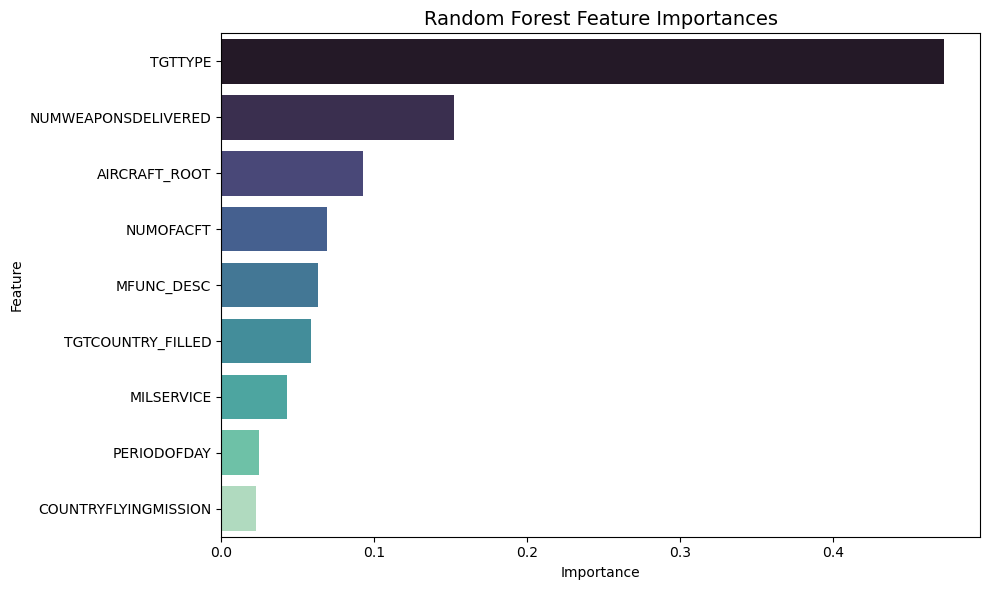

Accuracy: 0.794921514312096
AUC: 0.8564067512205242

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.87      0.85      6940
           1       0.74      0.65      0.70      3890

    accuracy                           0.79     10830
   macro avg       0.78      0.76      0.77     10830
weighted avg       0.79      0.79      0.79     10830



['Zini_ML/Success_predictors.pkl']

In [16]:
predictors = [
    'COUNTRYFLYINGMISSION', 'MILSERVICE', 'AIRCRAFT_ROOT', 'TGTTYPE',
    'NUMWEAPONSDELIVERED','MFUNC_DESC', 'NUMOFACFT', 'PERIODOFDAY', 'TGTCOUNTRY_FILLED'
]#list of predictors
cats = []; encoders = {}
rfdf = df2.copy() #make a copy of our df since we will be messing with labelencoder to use some text predictors
#get our non numeric columns for encoding
for col in predictors:
    if rfdf[col].dtype == 'object':
        cats.append(col)

for col in cats:
    if col in predictors:
        le = LabelEncoder()
        rfdf[col] = le.fit_transform(rfdf[col].astype(str))
        encoders[col] = le  # store for later use

X = rfdf[predictors]
y = rfdf['SUCCESS_FLAG']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

fi = pd.DataFrame({
    'feature': predictors,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

#Run the test set
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]  # probability of SUCCESS

# Feature Importance Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=fi,
    x="importance",
    y="feature",
    palette="mako"
)
plt.title("Random Forest Feature Importances", fontsize=14)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Show Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

joblib.dump(rf, "Zini_ML/Success_model.pkl")                  # your trained model
joblib.dump(encoders, "Zini_ML/Success_encoders.pkl")            # dict of encoders for cat cols
joblib.dump(predictors, "Zini_ML/Success_predictors.pkl")        # your list of predictor columns

### So we can see some pretty intuitive results- Tgt type is most of the predictive power. Trucks on a bridge vs enemy in the treeline. The more weapons on target, the higher chance of success, and the type of aircraft played a small role.

### 79% accurate at predicting the right outcome and 85% better than random guess-which could be interesting in a betting scenario...

### Lets see if we can make a prediction...

In [17]:
new_mission = {
    "COUNTRYFLYINGMISSION": "UNITED STATES OF AMERICA",
    "MILSERVICE": "USMC",
    "AIRCRAFT_ROOT": "A4",
    "TGTTYPE": "TRUCKS",
    "NUMWEAPONSDELIVERED": 6,
    "MFUNC_DESC": "STRIKE",
    "NUMOFACFT": 3,
    "PERIODOFDAY": "D",
    "TGTCOUNTRY_FILLED": "SOUTH VIETNAM"
}
new_df = pd.DataFrame([new_mission])
for col in cats:
    new_df[col] = encoders[col].transform(new_df[col].astype(str))
pred = rf.predict(new_df)
prob = rf.predict_proba(new_df)[:, 1]
print("Predicted Success Flag:", pred[0])
print("Probability of Success:", prob[0])

Predicted Success Flag: 1
Probability of Success: 0.6761778083028083


### Its interesting to see The success rates by mission type. CLose air support only has a 40% chance of success as far as recorded data shows. 

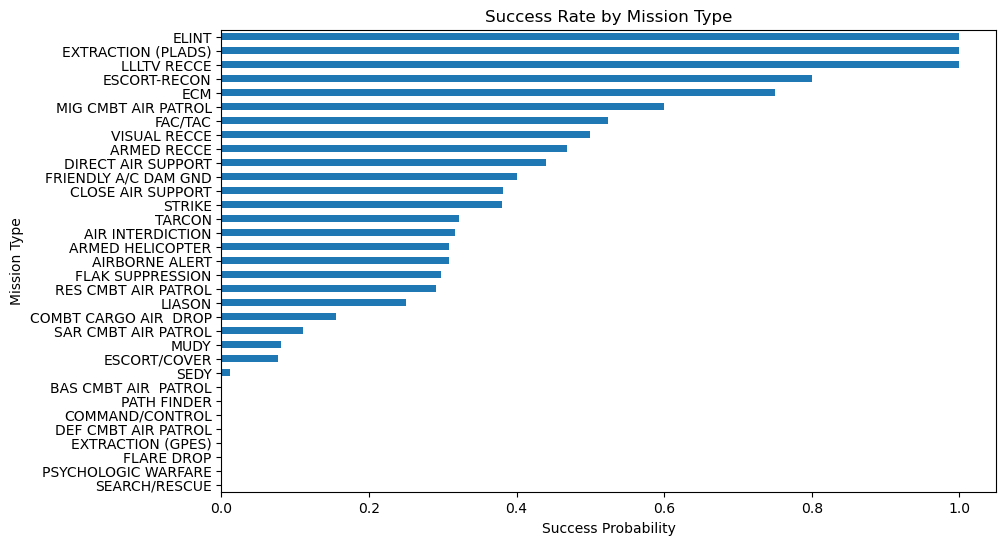

In [18]:
plt.figure(figsize=(10,6))
df2.groupby("MFUNC_DESC")["SUCCESS_FLAG"].mean().sort_values().plot(kind="barh")
plt.title("Success Rate by Mission Type")
plt.xlabel("Success Probability")   # x-axis now shows probabilities
plt.ylabel("Mission Type")      # y-axis now shows mission types
plt.show()


#### Predicting weather the mission was a success or fail could be interesting, but lets take a look at RNO

In [20]:
def classify_rno(v):
    success = ['CRATERED', 'DESTROYED', 'SILENCED', 'SECONDARY FIRE','SUSTAINED FIRE', 'CUT',
               'KILLED BY AIR', 'SEC EXPLOSION', 'PROB KILL DEST','DAMAGED','TIC BROKEN', 'WOUNDED BY AIR','OBSERVED']
    rno = ['RNO FOLIAGE','RNO ****','RNO NONVISUAL','RNO EXCSS DEF','RNO WEATHER','RNO EVASIVE','RNO SMOKE', 'RNO DARK','RNO FAC W/PASS','RNO-DLY BM/FU']
    fail = ['NODAMAGE MISS']
    unknown = ['GRASS FIRE', 'SLIDES','TARGET']
    if v in success:
        return "success"
    elif v in rno:
        return "rno"
    elif v in fail:
        return "fail"
    elif v in unknown:
        return "unknown"
    else:
        return "other"  # just in case something doesn’t match
dfrno = df2.copy()
dfrno["OUTCOME"] = dfrno["RESULTSBDA"].apply(classify_rno)
dfrno["RNO_FLAG"] = dfrno["OUTCOME"].map({"success": 0, "fail": 0, "unknown": 0, "rno": 1})
dfrno["OUTCOME"].value_counts()

OUTCOME
rno        26412
success    19450
unknown     6587
fail        1701
Name: count, dtype: int64

C:\Users\lucas\AppData\Local\Temp\ipykernel_11976\3163776539.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


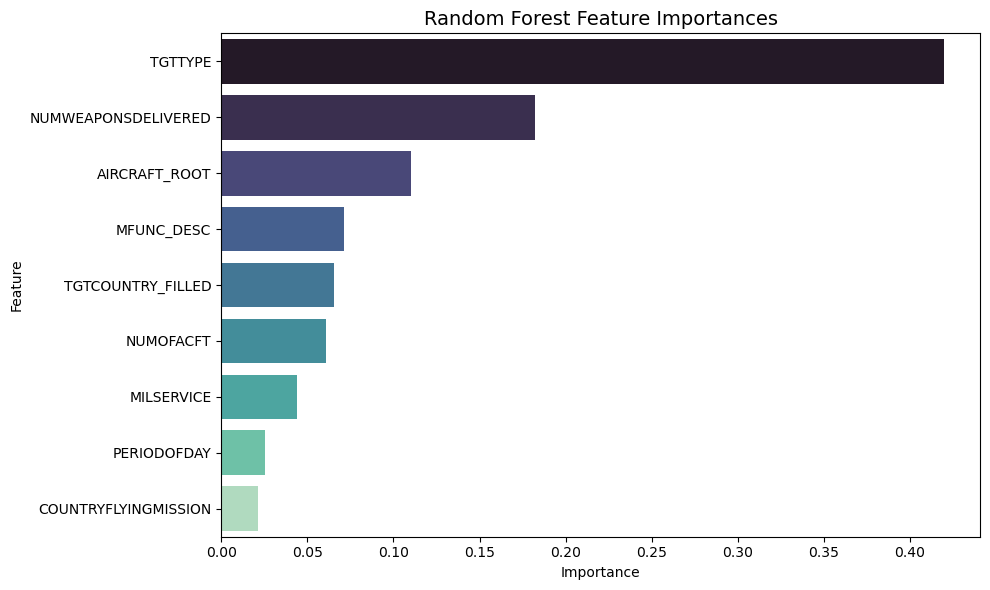

Accuracy: 0.8016620498614958
AUC: 0.8798267271660607

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.80      5548
           1       0.79      0.82      0.80      5282

    accuracy                           0.80     10830
   macro avg       0.80      0.80      0.80     10830
weighted avg       0.80      0.80      0.80     10830



['Zini_ML/RNO_predictors.pkl']

In [21]:
predictors = [
    'COUNTRYFLYINGMISSION', 'MILSERVICE', 'AIRCRAFT_ROOT', 'TGTTYPE',
    'NUMWEAPONSDELIVERED','MFUNC_DESC', 'NUMOFACFT', 'PERIODOFDAY', 'TGTCOUNTRY_FILLED'
]#list of predictors
cats = []; encoders = {}
rfdf = dfrno.copy() #make a copy of our df since we will be messing with labelencoder to use some text predictors
#get our non numeric columns for encoding
for col in predictors:
    if rfdf[col].dtype == 'object':
        cats.append(col)

for col in cats:
    if col in predictors:
        le = LabelEncoder()
        rfdf[col] = le.fit_transform(rfdf[col].astype(str))
        encoders[col] = le  # store for later use

X = rfdf[predictors]
y = rfdf['RNO_FLAG']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

fi = pd.DataFrame({
    'feature': predictors,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

#Run the test set
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]  # probability of SUCCESS
# Feature Importance Plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=fi,
    x="importance",
    y="feature",
    palette="mako"
)
plt.title("Random Forest Feature Importances", fontsize=14)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Show Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

joblib.dump(rf, "Zini_ML/RNO_model.pkl")                  # your trained model
joblib.dump(encoders, "Zini_ML/RNO_encoders.pkl")            # dict of encoders for cat cols
joblib.dump(predictors, "Zini_ML/RNO_predictors.pkl")        # your list of predictor columns

### Slightly better power here since the data is more even. In reality, given the time of the war, Knowing weather you could visualize the BDA or not would be helpful in managing expectations. If we were to fight again in the south pacific, we might run into similar issues, maybe less frequently due to advnaces in technology, however, knowing that i Have a 90% chance of not visualizing BDA of a certain mission and target, I could compensate for that accordingly.

In [22]:
new_mission = {
    "COUNTRYFLYINGMISSION": "UNITED STATES OF AMERICA",
    "MILSERVICE": "USAF",
    "AIRCRAFT_ROOT": "F4",
    "TGTTYPE": "CONFIRM ENEMY LOC",
    "NUMWEAPONSDELIVERED": 6,
    "MFUNC_DESC": "CLOSE AIR SUPPORT",
    "NUMOFACFT": 1,
    "PERIODOFDAY": "N",
    "TGTCOUNTRY_FILLED": "VIETNAM"
}
new_df = pd.DataFrame([new_mission])
for col in cats:
    new_df[col] = encoders[col].transform(new_df[col].astype(str))
pred = rf.predict(new_df)
prob = rf.predict_proba(new_df)[:, 1]
print("Predicted RNO Flag:", pred[0])
print("Probability of RNO:", prob[0])

Predicted RNO Flag: 0
Probability of RNO: 0.06416666666666666


### Our mission has a very low chance of being RNO, and is predicted to be not RNO. This is good so we have a high chance of knowing the effects of the mission on the enemy. "Did our mission achieve its endstate?" Without knowing success/fail, we cannot build effective tactics

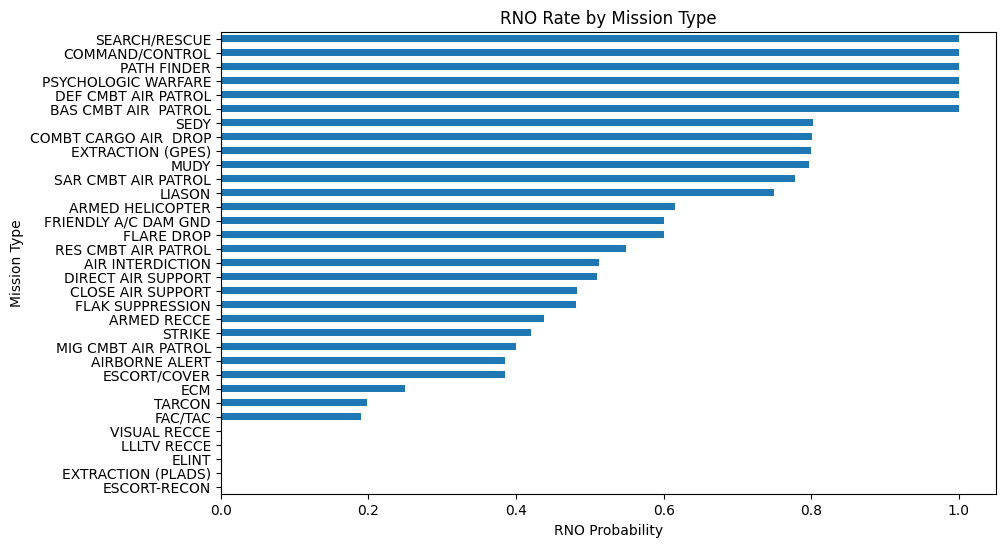

In [72]:
plt.figure(figsize=(10,6))
dfrno.groupby("MFUNC_DESC")["RNO_FLAG"].mean().sort_values().plot(kind="barh")
plt.title("RNO Rate by Mission Type")
plt.xlabel("RNO Probability")   # x-axis now shows probabilities
plt.ylabel("Mission Type")      # y-axis now shows mission types
plt.show()

### Interesting to see that Search/Rescue and Command/Control missions did not record actionable results. Is there any pattern towards areas where there where higher concentrations of RNO vs success Vs Fail?

In [19]:
df_rno = df2[df2["OUTCOME"] == "rno"]
df_success = df2[df2["OUTCOME"] == "success"]
df_fail = df2[df2["OUTCOME"] == "fail"]
coords_rno = df_rno[["TGTLATDD_DDD_WGS84","TGTLONDDD_DDD_WGS84"]].values.tolist()
coords_success = df_success[["TGTLATDD_DDD_WGS84","TGTLONDDD_DDD_WGS84"]].values.tolist()
coords_fail = df_fail[["TGTLATDD_DDD_WGS84","TGTLONDDD_DDD_WGS84"]].values.tolist()
m = folium.Map(
    location=[16.0, 106.0],
    zoom_start=6,
    tiles="CartoDB Dark_Matter")
layer_rno = folium.FeatureGroup(name="RNO Heatmap", show=True)
layer_success = folium.FeatureGroup(name="Success Heatmap", show=False)
layer_fail = folium.FeatureGroup(name="Failure Heatmap", show=False)

In [54]:
HeatMap(
    coords_rno,
    radius=5,
    blur=15,
    min_opacity=0.7
).add_to(layer_rno)

HeatMap(
    coords_success,
    radius=5,
    blur=15,
    min_opacity=0.7
).add_to(layer_success)

HeatMap(
    coords_fail,
    radius=5,
    blur=15,
    min_opacity=0.7
).add_to(layer_fail)
layer_rno.add_to(m)
layer_success.add_to(m)
layer_fail.add_to(m)
folium.LayerControl(collapsed=False).add_to(m)
m

In [ ]:
HeatMap(
    coords_rno,
    radius=6,
    blur=20,
    min_opacity=0.7,
    gradient={
        0.0: "#f0000f",   # neon magenta
        1.0: "#ffffff"    # white hot
    }
).add_to(layer_rno)

HeatMap(
    coords_success,
    radius=6,
    blur=20,
    min_opacity=0.7,
    gradient={
        0.0: "#00ffff",   # neon cyan
        1.0: "#ffffff"
    }
).add_to(layer_success)

HeatMap(
    coords_fail,
    radius=6,
    blur=20,
    min_opacity=0.7,
    gradient={
        0.0: "#33ff00",   # neon green
        1.0: "#ffffff"
    }
).add_to(layer_fail)

ho_chi_minh_trail = [
    [21.10, 105.90],
    [20.30, 105.40],
    [19.60, 105.30],
    [18.30, 105.20],
    [17.60, 105.30],
    [16.60, 106.00],
    [15.00, 107.00],
    [14.50, 107.60],
    [13.80, 107.80],
    [12.50, 107.90],
    [11.50, 107.60],
    [10.90, 106.70]
]

# Add trail to map
folium.PolyLine(
    ho_chi_minh_trail,
    color="cyan",
    weight=4,
    opacity=0.85
).add_to(m)
layer_rno.add_to(m)
layer_success.add_to(m)
layer_fail.add_to(m)
folium.LayerControl(collapsed=False).add_to(m)

In [ ]:
    blur=20,
    min_opacity=0.7,
    gradient={
        0.0: "#f0000f",   # neon magenta
        1.0: "#ffffff"    # white hot
    }
).add_to(layer_rno)

HeatMap(
    coords_success,
    radius=6,
    blur=20,
    min_opacity=0.7,
    gradient={
        0.0: "#00ffff",   # neon cyan
        1.0: "#ffffff"
    }
).add_to(layer_success)

HeatMap(
    coords_fail,
    radius=6,
    blur=20,
    min_opacity=0.7,
    gradient={
        0.0: "#33ff00",   # neon green
        1.0: "#ffffff"
    }
).add_to(layer_fail)

ho_chi_minh_trail = [
    [21.10, 105.90],
    [20.30, 105.40],
    [19.60, 105.30],
    [18.30, 105.20],
    [17.60, 105.30],
    [16.60, 106.00],
    [15.00, 107.00],
    [14.50, 107.60],
    [13.80, 107.80],
    [12.50, 107.90],
    [11.50, 107.60],
    [10.90, 106.70]
]

# Add trail to map
folium.PolyLine(
    ho_chi_minh_trail,
    color="cyan",
    weight=4,
    opacity=0.85
).add_to(m)
layer_rno.add_to(m)
layer_success.add_to(m)
layer_fail.add_to(m)
folium.LayerControl(collapsed=False).add_to(m)

### As expected, just with 50,000 missions, extrapolate that to over a million, and the RNO, Success, and Fail categories overlap most everywhere.

In [51]:
coords = df_rno[["TGTLATDD_DDD_WGS84","TGTLONDDD_DDD_WGS84"]].values.tolist()

m = folium.Map(
    location=[16.0,106.0],
    zoom_start=6,
    tiles="CartoDB Dark_Matter"
)

HeatMap(
    coords,
    radius=8,
    blur=15,
    min_opacity=0.5,
).add_to(m)

m

In [21]:
m

In [53]:
from folium.plugins import HeatMap
import folium

# RNO coordinates
coords = df_rno[["TGTLATDD_DDD_WGS84","TGTLONDDD_DDD_WGS84"]].values.tolist()

# Base map
m = folium.Map(
    location=[16.0, 106.0],
    zoom_start=6,
    tiles="CartoDB Dark_Matter"
)

# Heatmap
HeatMap(
    coords,
    radius=5,
    blur=15,
    min_opacity=0.9
).add_to(m)

# Ho Chi Minh Trail coordinates
ho_chi_minh_trail = [
    [21.10, 105.90],
    [20.30, 105.40],
    [19.60, 105.30],
    [18.30, 105.20],
    [17.60, 105.30],
    [16.60, 106.00],
    [15.00, 107.00],
    [14.50, 107.60],
    [13.80, 107.80],
    [12.50, 107.90],
    [11.50, 107.60],
    [10.90, 106.70]
]

# Add trail to map
folium.PolyLine(
    ho_chi_minh_trail,
    color="cyan",
    weight=4,
    opacity=0.85
).add_to(m)

m
